In [1]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import Robustness_Analysis
from mads_testing_stuff import RA_test_env, RA_test_precision_env

from IPython.display import display

In [2]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(RA_test_env)

<module 'mads_testing_stuff.RA_test_env' from 'D:\\Professionelt\\Code\\volpy\\mads_testing_stuff\\RA_test_env.py'>

12 -> 2:20 min

50 -> 16:00 min

In [85]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(RA_test_env)
importlib.reload(Robustness_Analysis)
importlib.reload(RA_test_precision_env)


od_RA = Robustness_Analysis.create_fake_option_df(1/12)

# parameter dicts you already have:
bs_params =    {'sigma':0.37, 'r':0.056}
mjd_params =   {'sigma':0.35, 'lam':0.4, 'mu_J':-0.09, 'sigma_J':0.18, 'r':0.056}
heston_params = {'kappa': 1.04, 'theta': 0.37**2, 'xi': 0.9, 'rho': -0.7}
svmjd_params = {**mjd_params, **heston_params}
svmjd_params['theta'] = 0.35**2
svmjd_params.pop('sigma', None)

# 1) build your list‐of‐values column…
ln_vt_theta_vals = np.linspace(-3, 3, 13)
od_RA['ln vt/theta'] = od_RA['ticker'].apply(lambda t: [0] if t in ['BS','MJD'] else ln_vt_theta_vals)

# 2) explode it into real rows
od_RA = od_RA.explode('ln vt/theta').reset_index(drop=True)

# 3) coerce to float64
od_RA['ln vt/theta'] = od_RA['ln vt/theta'].astype(float)

# 4) now your v0 vectorized will work
def compute_v0(row):
    if row['ticker'] == 'BS':
        return bs_params['sigma']**2
    elif row['ticker'] == 'MJD':
        return mjd_params['sigma']**2
    elif row['ticker'] == 'Heston':
        return (np.exp(row['ln vt/theta']) * heston_params['theta'])
    elif row['ticker'] == 'SVMJD':
        return (np.exp(row['ln vt/theta']) * svmjd_params['theta'])
    else:
        return np.nan

od_RA['v0'] = od_RA.apply(compute_v0, axis=1)

# fill your DataFrame’s IV column:
od_RA['Price'] = Robustness_Analysis.price_model(
    od_RA['F'].values,
    od_RA['K'].values,
    od_RA['t_TTM'].values,
    od_RA['cp_flag'].values,
    od_RA['ticker'].values,
    od_RA['v0'].values,
    bs_params,
    mjd_params,
    heston_params,
    svmjd_params,
    high_precision = False
)
od_RA['IV'] = vp.add_bid_mid_ask_IV(od_RA, "Price", safer_version=True)

In [86]:
od_RA["date"] = od_RA["v0"]
df_swaps_low = vp.process_od_rdy_parallel(od_RA[od_RA["low"]], vp.replicate_SW_k, n_points=10000)
df_swaps_high = vp.process_od_rdy_parallel(od_RA[od_RA["high"]], vp.replicate_SW_k, n_points=10000)
od_RA.rename(columns={"ticker": "model"}, inplace=True)

# 2) Extract low/high rows and merge
df_low = (
    df_swaps_low
    .drop_duplicates(["ticker", "v0"])
    .loc[:, ["ticker", "v0", "var_swap_rate", "ln vt/theta"]]
    .rename(columns={"var_swap_rate": "low SW"})
)

df_high = (
    df_swaps_high
    .drop_duplicates(["ticker", "v0"])
    .loc[:, ["ticker", "v0", "var_swap_rate"]]
    .rename(columns={"var_swap_rate": "high SW"})
)

df_merged = pd.merge(df_low, df_high, on=["ticker", "v0"], how="outer")
df_merged.set_index(["ticker", "ln vt/theta"], inplace=True)

Processing Groups: 100%|██████████| 28/28 [00:02<00:00,  9.42it/s]


In [87]:
dt = 1/12
A = (1 - np.exp(-svmjd_params['kappa']*dt)) / (svmjd_params['kappa']*dt)

# Compute analytic value per row
def v_t_analytic_value(row):
    model = row["model"]  # ticker is the index
    v0 = row['v0']
    if model == 'BS':
        v_t = bs_params['sigma']**2
        E_v = v_t
        return v_t, E_v
    elif model == 'MJD':
        v_t = mjd_params['sigma']**2
        E_v = v_t + mjd_params['lam'] * (mjd_params['mu_J']**2 + mjd_params['sigma_J']**2)
        return v_t, E_v
    elif model == 'Heston':
        v_t = heston_params['theta'] + A * (v0 - heston_params['theta'])
        E_v = v_t
        return v_t, E_v
    elif model == 'SVMJD':
        v_t = svmjd_params['theta'] + A * (v0 - svmjd_params['theta'])
        E_v = v_t + svmjd_params['lam'] * (svmjd_params['mu_J']**2 + svmjd_params['sigma_J']**2)
        return v_t, E_v
    else:
        return np.nan, np.nan

df_merged.reset_index(inplace=True)
df_merged.rename(columns={"ticker": "model"}, inplace=True)
df_merged.rename(columns={"low SW": "SW"}, inplace=True)

df_merged[['sigma_t^2', 'analytic']] = df_merged.apply(
    v_t_analytic_value,
    axis=1,
    result_type='expand'
)

df_merged['error'] = df_merged['analytic'] - df_merged['SW']
df_merged['error pct'] = df_merged['error'] / df_merged['analytic'] * 100
df_merged['error high'] = df_merged['analytic'] - df_merged['high SW']
df_merged['error pct high'] = df_merged['error high'] / df_merged['analytic'] * 100
df_merged['error jmp'] = -2 * mjd_params['lam'] * (np.exp(mjd_params['mu_J'] + 0.5*mjd_params['sigma_J']**2) - 1 - mjd_params['mu_J'] - 0.5*(mjd_params['mu_J']**2 + mjd_params['sigma_J']**2))
df_merged.loc[df_merged["model"].isin(["BS", "Heston"]), "error jmp"] = 0

cols_to_front = ["model", "ln vt/theta", "sigma_t^2", "analytic", "SW", "error", "error pct", "error jmp"]
remaining_cols = [col for col in df_merged.columns if col not in cols_to_front]
df_merged = df_merged[cols_to_front + remaining_cols]

In [1]:
# # k (denser grid)
# with pd.option_context('display.max_rows', None, 'display.float_format', '{:.4f}'.format):
#     display(df_merged)

In [128]:
importlib.reload(Robustness_Analysis)
Robustness_Analysis.main_table(df_merged)

\begin{table}[ht]
    \centering
    \begin{tabular}{lccccccc}
        \toprule
        $\ln(v_t/\theta)$ & $v_0$ & $\sigma_t^2$ & $\mathbb{E^Q}[RV]$ & $\widehat{SW}$ & Total error & Percentage error & Jump error $(\varepsilon)$ \\[-0.5ex]
        &  &  &  &  & $(\mathbb{E^Q}[RV]-\widehat{SW})$ & $(\text{Total error} / \mathbb{E^Q}[RV])$ &  \\
        \midrule
        \multicolumn{8}{l}{\textbf{Black–Scholes (BS) model}}\\
        0.0 & 0.1369 & 0.1369 & 0.1369 & 0.1369 & 0.0000 & 0.0000 & - \\
        \midrule
        \multicolumn{8}{l}{\textbf{Stochastic volatility (Heston) model}}\\
        -3.0 & 0.0068 & 0.0123 & 0.0123 & 0.0127 & -0.0004 & -3.1907 & - \\
        -2.5 & 0.0112 & 0.0165 & 0.0165 & 0.0171 & -0.0006 & -3.4059 & - \\
        -2.0 & 0.0185 & 0.0235 & 0.0235 & 0.0242 & -0.0007 & -3.1000 & - \\
        -1.5 & 0.0305 & 0.0350 & 0.0350 & 0.0357 & -0.0007 & -1.9779 & - \\
        -1.0 & 0.0504 & 0.0540 & 0.0540 & 0.0542 & -0.0002 & -0.4038 & - \\
        -0.5 & 0.0830 & 0.0

# Start here

In [121]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def foo(df, pm_std = 1.5):
    r = df["r"].iloc[0]
    T = df["t_TTM"].iloc[0]  # T in years (e.g. days / 365)
    K_data = df["K"].values
    iv_data = df["IV"].values
    F = df["F"].mean()
    stdev = df["IV"].mean()
    k_min = -pm_std * stdev
    k_max = pm_std * stdev
    k_grid = np.linspace(k_min, k_max, 10000)
    K_grid = F * np.exp(k_grid)
    iv_grid = np.interp(K_grid, K_data, iv_data,
                    left=iv_data[0],
                    right=iv_data[-1])
    is_call = (K_grid > F)  # Boolean array for call/put decision
    # d1 = (np.log(F / K_grid) + (r + 0.5 * iv_grid ** 2) * T) / (iv_grid * np.sqrt(T)) # Not the forward method (r should be removed)
    d1 = (np.log(F / K_grid) + 0.5 * iv_grid ** 2 * T) / (iv_grid * np.sqrt(T))
    d2 = d1 - iv_grid * np.sqrt(T)
    call_prices = np.exp(-r * T) * (F * norm.cdf(d1) - K_grid * norm.cdf(d2))
    put_prices = call_prices - np.exp(-r * T) * (F - K_grid)
    option_prices = np.where(is_call, call_prices, put_prices)

    # The OTM option price from BSM_call_put is discounted, so multiply by e^{rT}.
    undiscounted_option_prices = option_prices * np.exp(r * T)
    integrand = undiscounted_option_prices * 2/K_grid**2
    
    return K_grid, iv_grid, undiscounted_option_prices, integrand

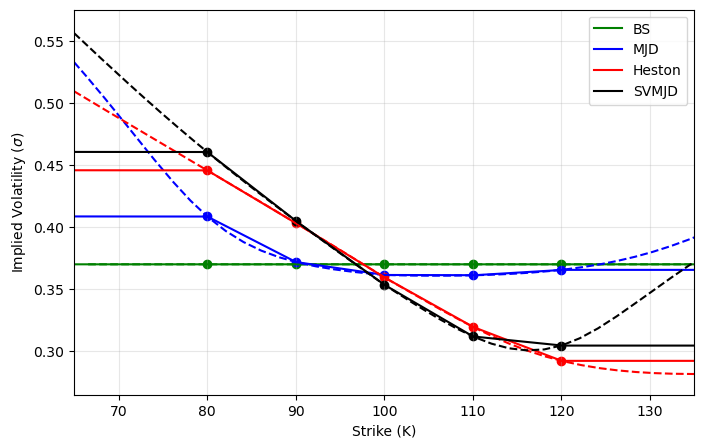

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["BS", "MJD", "Heston", "SVMJD"]
color_list = ["green", "blue", "red", "black"]
vt = 0
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.xlim((65,135))
plt.ylim(0.265, 0.575)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt0_all_models.pdf")
plt.show()

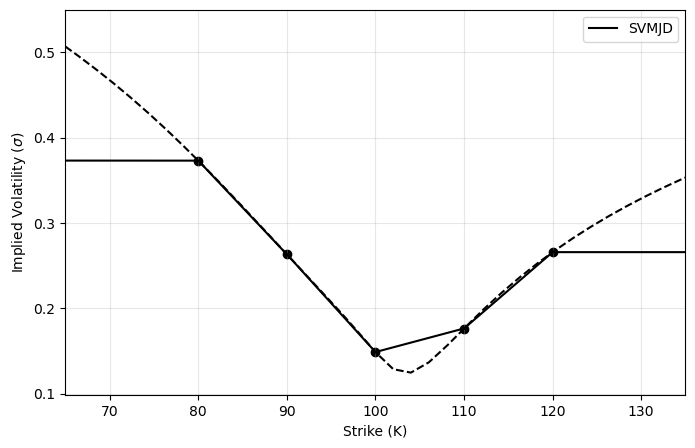

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = -2
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
plt.ylim(None, 0.55)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt-2_SVMJD.pdf")
plt.show()

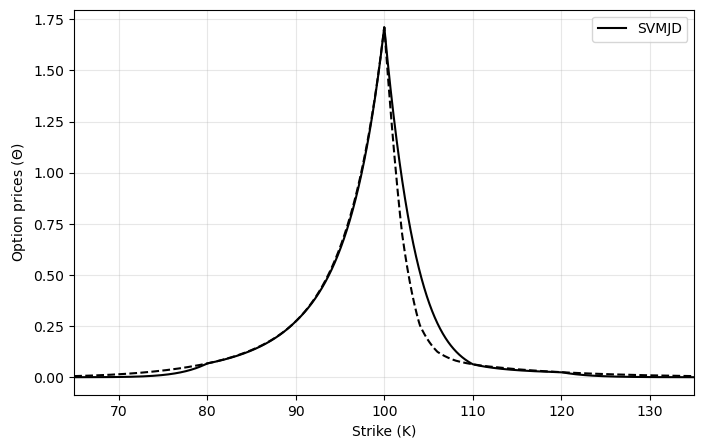

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = -2
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, undiscounted_option_prices, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, undiscounted_option_prices, linestyle="--", color=colors[model])

plt.ylabel(r"Option prices ($\Theta$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
plt.legend()
plt.savefig("figures/Robustness_analysis_price_vt-2_SVMJD.pdf")
plt.show()

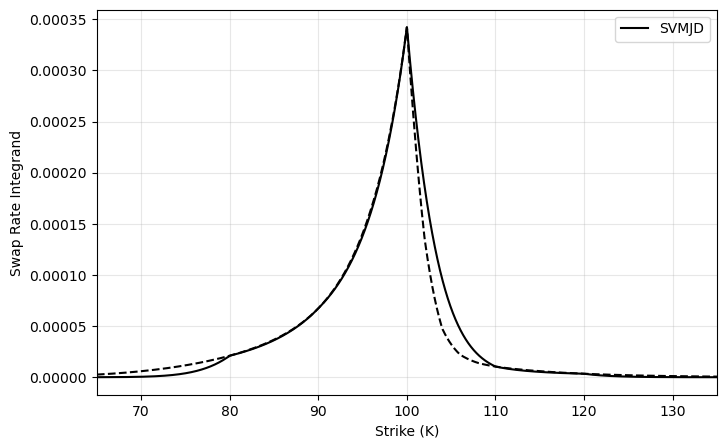

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = -2
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, integrand, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, integrand, linestyle="--", color=colors[model])

plt.ylabel(r"Swap Rate Integrand")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
plt.legend()
plt.savefig("figures/Robustness_analysis_integrand_vt-2_SVMJD.pdf")
plt.show()

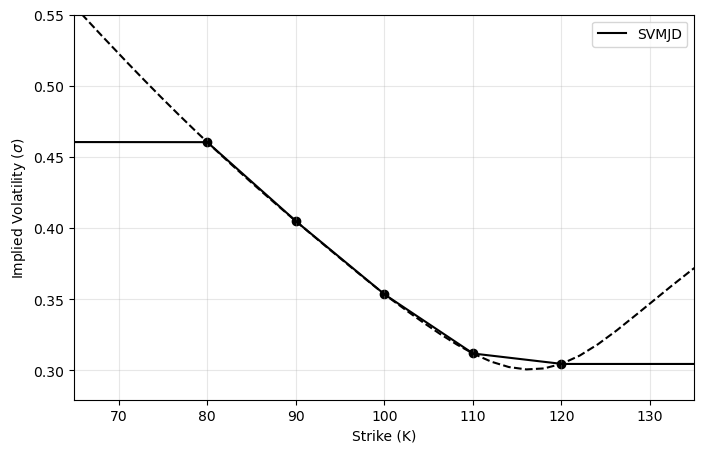

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = 0
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
plt.ylim(None, 0.55)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt0_SVMJD.pdf")
plt.show()

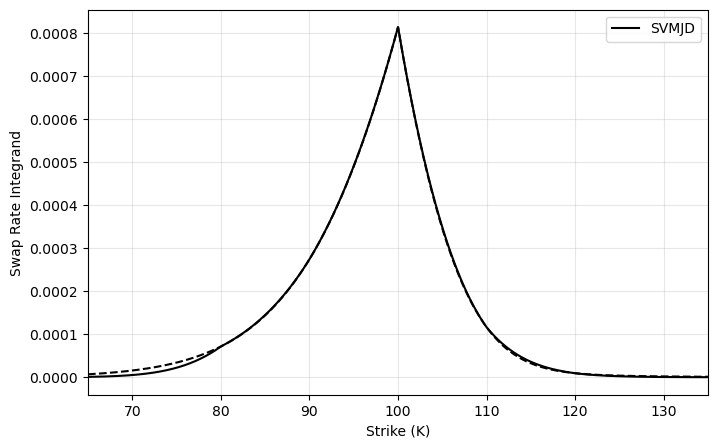

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["SVMJD"]
color_list = ["black"]
vt = 0
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, integrand, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, integrand, linestyle="--", color=colors[model])

plt.ylabel(r"Swap Rate Integrand")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
plt.legend()
plt.savefig("figures/Robustness_analysis_integrand_vt0_SVMJD.pdf")
plt.show()

## Cut pga problem

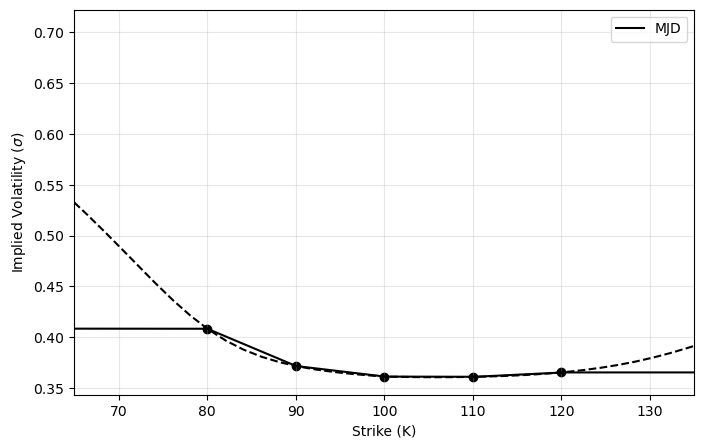

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["MJD"]
color_list = ["black"]
vt = 3
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
# plt.ylim(0.25, 0.55)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt0_SVMJD.pdf")
plt.show()

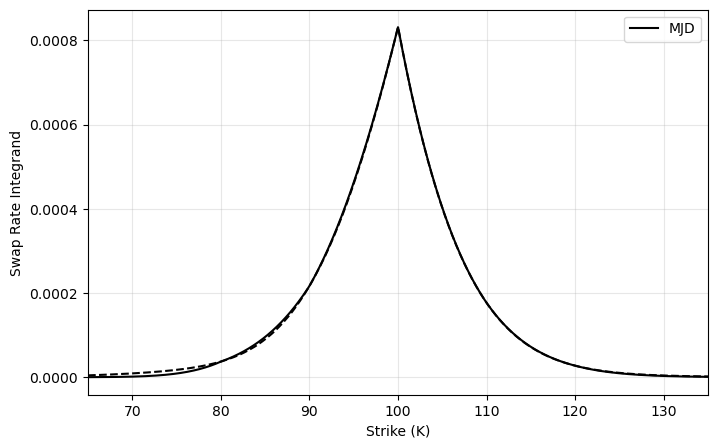

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["MJD"]
color_list = ["black"]
vt = -0
pm_std = 2

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    line, = plt.plot(K_grid, integrand, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    # df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, integrand, linestyle="--", color=colors[model])

plt.ylabel(r"Swap Rate Integrand")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.xlim((65,135))
plt.legend()
# plt.savefig("figures/Robustness_analysis_integrand_vt-2_SVMJD.pdf")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
model_list = ["Heston", "SVMJD"]
color_list = ["red", "black"]
vt = -2
pm_std = 1.5

od_RA_ = od_RA[(od_RA["ln vt/theta"] == vt) | (od_RA["model"].isin(["BS", "MJD"]))].copy()
od_RA_ = od_RA_[od_RA_["model"].isin(model_list)].copy()
low_df = od_RA_[od_RA_["low"] == True].copy()
high_df = od_RA_[od_RA_["high"] == True].copy()

colors = {}  # store colors to ensure consistency

for model, color in zip(model_list, color_list):
        
    # Filter and plot the "low" line (solid)
    df_low = low_df[low_df["model"] == model].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_low, pm_std=pm_std)
    
    plt.scatter(df_low["K"], df_low["IV"], color = color)
    line, = plt.plot(K_grid, iv_grid, label=f"{model}", color = color)
    colors[model] = line.get_color()  # Save color used for this model

    # Filter and plot the "high" line (dashed)
    df_high = high_df[high_df["model"] == model].copy()
    df_high = df_high[(df_high["K"] >= df_low["K"].min()) & (df_high["K"] <= df_low["K"].max())].copy()
    K_grid, iv_grid, undiscounted_option_prices, integrand = foo(df_high, pm_std=pm_std)
    
    colors[model] = line.get_color()  # Save color used for this model

    plt.plot(K_grid, iv_grid, linestyle="--", color=colors[model])

plt.ylabel(r"Implied Volatility ($\sigma$)")
plt.xlabel("Strike (K)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("figures/Robustness_analysis_IV_vt-2_SV_models.pdf")
plt.show()

# End